# BDMI inocmpatibilities / gene interactions?

Install `bitarrays`:

In [1]:
# conda install -c conda-forge bitarray

Imports:

In [1]:
import numpy as np
import pandas as pd
from math import log
from scipy.stats import binom
from bitarray import bitarray
from bitarray.util import count_xor, zeros
from numpy.random import randint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("ticks")
# scale plots
sns.set_context("paper")
# import matplotlib as mpl
# scale = 0.8
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
# d['figure.figsize'] = [5.4, 3.5]
# mpl.rcParams.update(d)

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

## Test data

Function for making chrX dataframes like the ones you have. Admixture is 50% and random except for two pairs of windows with mixes ancestry that match up perfectly and one pair of windows with uniform ancestry that match up perfectly. For simplicity I assume only males for now.

In [4]:
admix_prop = 0.2
np.random.choice([0, 1], size=10, p=[1-admix_prop, admix_prop])

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [52]:
def dummy_data(window_size, admix_prob, nr_indivs, par1_size):

    begin = (par1_size // window_size + 1) * window_size
    a = np.array(range(begin, 153000000, window_size))
    nr_windows = len(a)
    lst = []
    for indiv in range(0, nr_indivs):
        df = pd.DataFrame(dict(start=a, 
                               end=a+window_size, 
                               is_north=np.random.choice([0, 1], size=nr_windows, p=[1-admix_prop, admix_prop])
                              )
                         )
        df['male'] = indiv
        lst.append(df)
    df = pd.concat(lst)
    df = df[['male', 'start', 'end', 'is_north']]
    
    # add a single window 30000000 with perfect match to window 50000000
    males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
    df.loc[(df.start == 30000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 30000000), 'is_north'] = 1
    df.loc[(df.start == 50000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 50000000), 'is_north'] = 1

    # add a single window 40000000 with perfect match to window 60000000
    males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
    df.loc[(df.start == 40000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 40000000), 'is_north'] = 1
    df.loc[(df.start == 60000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 60000000), 'is_north'] = 1
    
    # add a single homogeneous window 80000000 with perfect match to window 100000000
    df.loc[(df.start == 80000000), 'is_north'] = 1
    df.loc[(df.start == 100000000), 'is_north'] = 1

    df['admix_prop'] = 0
    df.loc[df.is_north == 1, 'admix_prop'] = 1 - np.abs(np.random.random(len(df.loc[df.is_north == 1]))) / 4
    df.loc[df.is_north == 0, 'admix_prop'] = np.abs(np.random.random(len(df.loc[df.is_north == 0]))) / 4
    
    # # round admix proportion to 0 / 1: is north or not
    # df['is_north'] = df.admix_prop.round().astype(int)
    
    return df

df = dummy_data(100000, 0.3, 100, 2600000)  
df.head()

,male,start,end,is_north,admix_prop
0,0,2700000,2800000,0,0.114538
1,0,2800000,2900000,1,0.971254
2,0,2900000,3000000,0,0.031949
3,0,3000000,3100000,0,0.226676
4,0,3100000,3200000,1,0.754078


In [53]:
# def dummy_data(window_size, admix_prob, nr_indivs, par1_size):

#     begin = (par1_size // window_size + 1) * window_size
#     a = np.array(range(begin, 153000000, window_size))
#     nr_windows = len(a)
#     lst = []
#     for indiv in range(0, nr_indivs):
#         df = pd.DataFrame(dict(start=a, end=a+window_size, admix_prop=1-np.random.random(size=nr_windows)))
#         df['male'] = indiv
#         lst.append(df)
#     df = pd.concat(lst)
#     df = df[['male', 'start', 'end', 'admix_prop']]
    
#     # add a single window 30000000 with perfect match to window 50000000
#     males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
#     df.loc[(df.start == 30000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 30000000), 'admix_prop'] = 1
#     df.loc[(df.start == 50000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 50000000), 'admix_prop'] = 1

#     # add a single window 40000000 with perfect match to window 60000000
#     males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
#     df.loc[(df.start == 40000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 40000000), 'admix_prop'] = 1
#     df.loc[(df.start == 60000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 60000000), 'admix_prop'] = 1
    
#     # add a single homogeneous window 80000000 with perfect match to window 100000000
#     df.loc[(df.start == 80000000), 'admix_prop'] = 1
#     df.loc[(df.start == 100000000), 'admix_prop'] = 1

#     # round admix proportion to 0 / 1: is north or not
#     df['is_north'] = df.admix_prop.round().astype(int)
    
#     return df

# df = dummy_data(100000, 100, 2600000)  
# df.head()

## Pairing statistics

Functions for computing two statistics for pairs of windows using bitarrays:

- Proportion of piared ancestry: the proportion of individuals that have the same ancestry in the two windows.
- Mutual information: mutual information across between the two windows (assumes 50% admixture for now).

`compute_matrix` returns candidate pairs for windows and the matrix of all stats for plotting. "significant" pairs are:

- Proportion of piared ancestry: bernoulli corrected binomial significance.
- Mutual information: 0.9 * perfect mutual information for the sample size (assumes 50% admixture for now).

In [64]:
def get_pairs(m, cutoff):
    m = m.copy()
    np.fill_diagonal(m, 0)
    dependent_windows = np.argwhere((m > cutoff))
    dependent_windows.sort()
    dependent_windows = np.unique(dependent_windows[dependent_windows[:, 0].argsort()], axis=0)
    return dependent_windows.tolist()


def bitarray_mut_info(b1, b2):
    epsilon = 1e-12
    x11 = (b1 & b2).count(1) + epsilon 
    x10 = (b1 ^ b2 & b1).count(1) + epsilon 
    x01 = (b2 ^ b1 & b2).count(1) + epsilon 
    x00 = (b1 | b2).count(0) + epsilon 
    tot = x11 + x10 + x01 + x00
    x11 /= tot
    x10 /= tot
    x01 /= tot
    x00 /= tot
    x_1 = x11 + x01
    x1_ = x11 + x10
    x_0 = x00 + x10
    x0_ = x00 + x01
    mut_info = x11*log(x11/(x1_*x_1)) + x10*log(x10/(x1_*x_0)) + x01*log(x01/(x0_*x_1)) + x00*log(x00/(x0_*x_0))
    return mut_info


def compute_matrix(df, stat='proportion_paired'):

    grouped = df.groupby('start')
    nr_indivs = grouped.agg('size').max()
    window_size = (df.end - df.start).max()
    nr_windows = grouped.ngroups

    columns = {}
    for start, group in grouped:
        columns[start] = bitarray(group.is_north.tolist())
        
    index_array = np.array(np.meshgrid(range(nr_windows), range(nr_windows))) * window_size

    def proportion_paired(args):
        i, j = args
        if i in columns and j in columns:
            return (nr_indivs - count_xor(columns[i], columns[j])) / nr_indivs
        else:
            return np.nan

    # def fun(args):
    #     i, j = args
    #     if i in columns and j in columns:
    #         return mutual_info_score(columns[i].tolist(), columns[j].tolist())
    #     else:
    #         return np.nan
    
    def mutual_information(args):
        i, j = args
        if i in columns and j in columns:
            return bitarray_mut_info(columns[i], columns[j])
        else:
            return np.nan    
        
    mean_admix_prop = df.is_north.mean()
    match_prob = mean_admix_prop**2 + (1-mean_admix_prop)**2
        
    if stat == 'prop_paired':
        m = np.apply_along_axis(proportion_paired, 0, index_array)
        p_value = 1 / df.start.nunique()**2
        min_signif = binom.ppf(1-p_value, nr_indiv, match_prob) / nr_indiv
        interacting_windows = get_pairs(m, min_signif)        
        return interacting_windows, m        
    elif stat == 'mut_info':
        m = np.apply_along_axis(mutual_information, 0, index_array)
        
        lst = []
        for _ in range(100):
            b = bitarray(np.random.choice([0, 1], size=nr_windows, p=[1-mean_admix_prop, mean_admix_prop]).tolist())
            # b = bitarray(np.random.randint(0, 2, size=nr_indivs).tolist())
            lst.append(bitarray_mut_info(b, ~b))
        perfect = sum(lst)/len(lst) # mut info for perfectly matching cols (assuming 0.5 admixture prop)
        interacting_windows = get_pairs(m, perfect*0.95) 
        return interacting_windows, m            
    else:
        assert 0

## Testing it

Make a test data frame:

In [69]:
# window_size = 1000000 # 1mb
window_size = 100000 # 100kb
# window_size = 10000 # 10kb
par1_size = 2600000
nr_indiv = 25
admix_prop = 0.2
df = dummy_data(window_size, admix_prop, nr_indiv, par1_size)

Compute proportion paired:

In [70]:
%%time
pp_interacting_windows, pp_m = compute_matrix(df, stat='prop_paired')

CPU times: user 2.87 s, sys: 21.9 ms, total: 2.89 s
Wall time: 2.89 s


Compute mutual information:

In [71]:
%%time
mi_interacting_windows, mi_m = compute_matrix(df, stat='mut_info')

CPU times: user 5.07 s, sys: 25.7 ms, total: 5.09 s
Wall time: 5.09 s


Plot matrices with lines connecting interacting pairs found by each method:

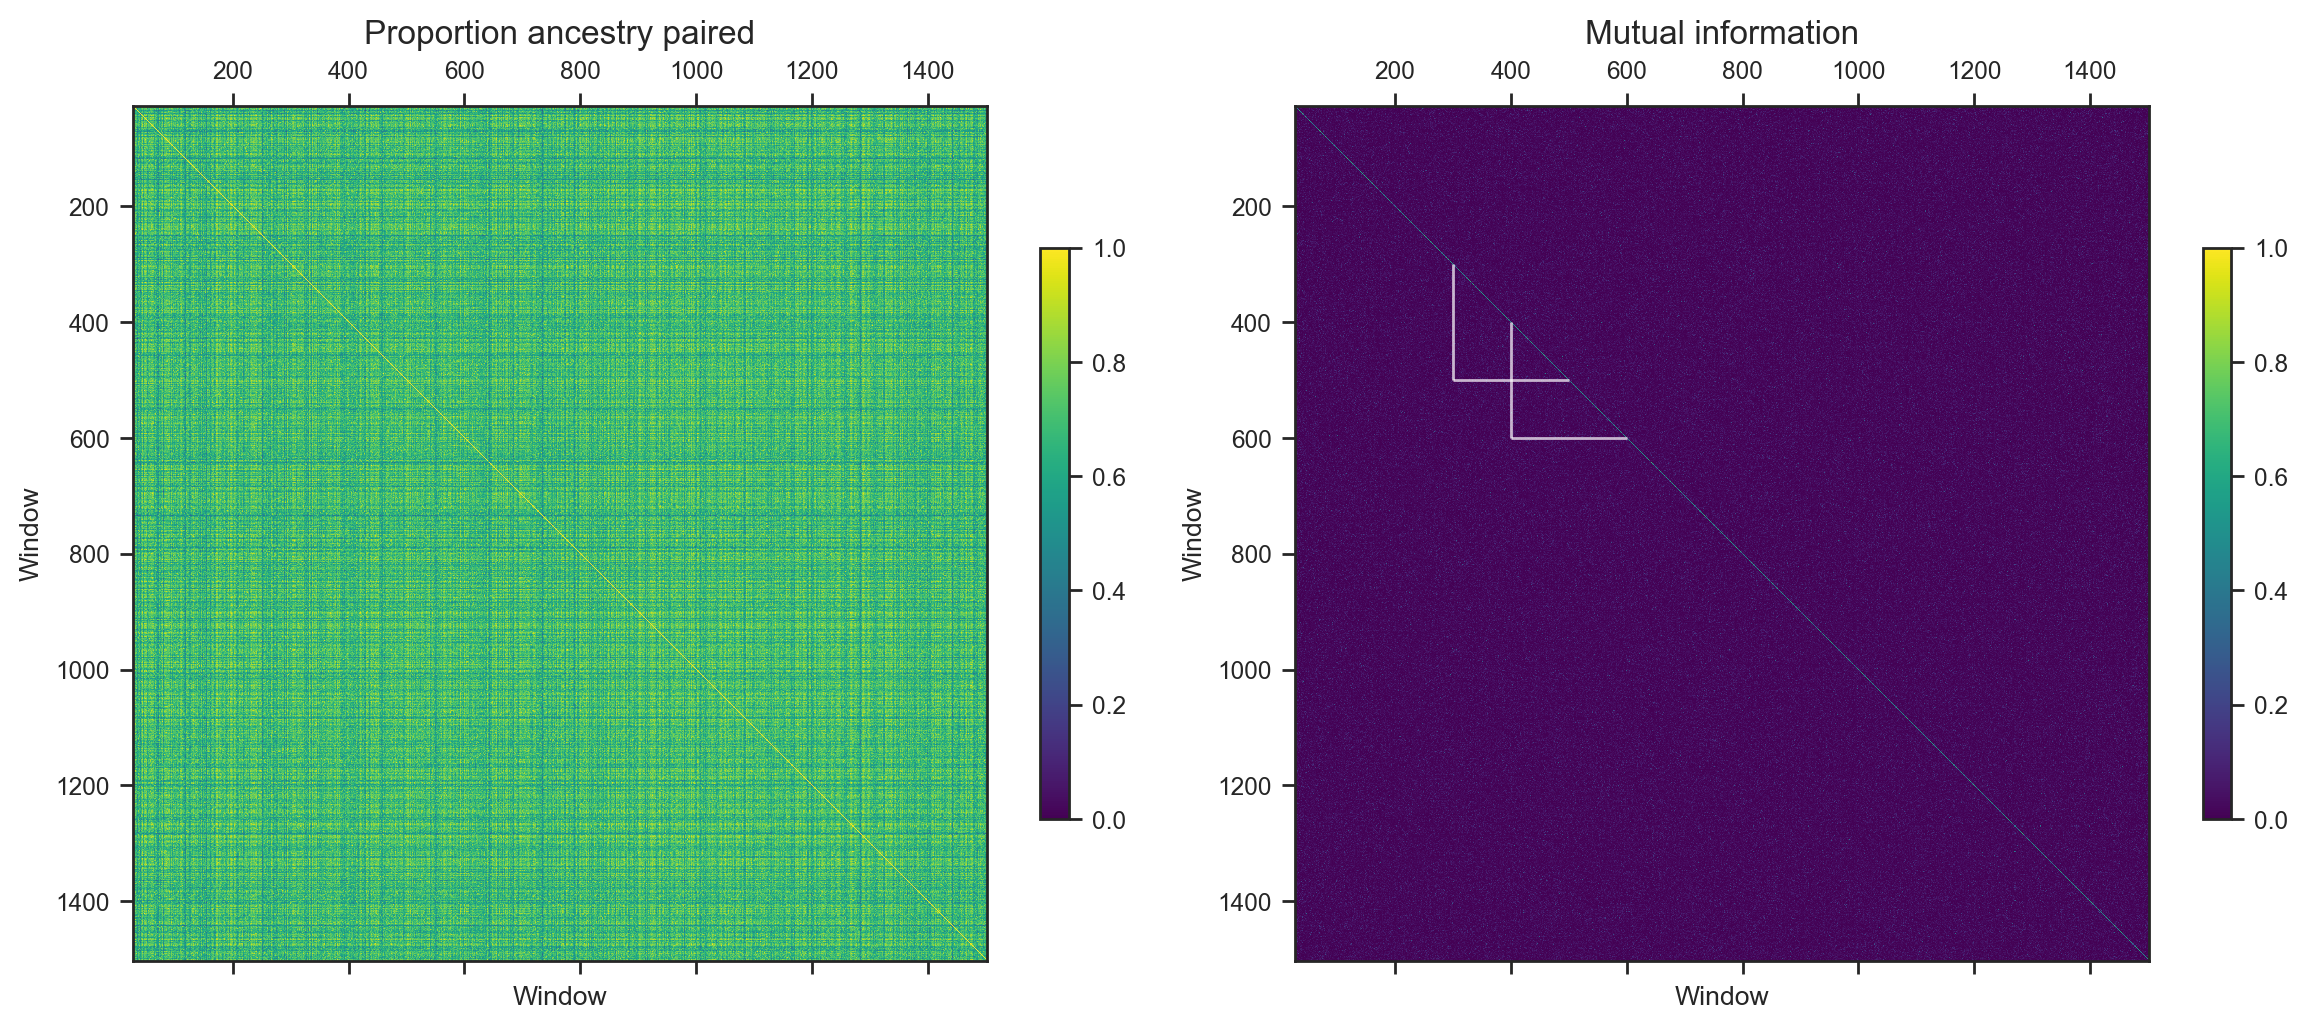

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
g = ax1.matshow(pp_m, cmap='viridis', vmin=0, vmax=1)
ax1.set_xlim(left=(par1_size//window_size)+1)
ax1.set_ylim(top=(par1_size//window_size)+1)
ax1.set_xlabel('Window')
ax1.set_ylabel('Window')
ax1.set_title('Proportion ancestry paired', fontsize=12)
cb = fig.colorbar(g, location='right', ax=ax1, shrink=0.5)
for a, b in pp_interacting_windows:
    ax1.vlines(a, a, b, color='white', linewidth=1, alpha=0.7)
    ax1.hlines(b, b, a, color='white', linewidth=1, alpha=0.7)
g = ax2.matshow(mi_m, cmap='viridis', vmin=0, vmax=1)
ax2.set_xlim(left=(par1_size//window_size)+1)
ax2.set_ylim(top=(par1_size//window_size)+1)
ax2.set_xlabel('Window')
ax2.set_ylabel('Window')
ax2.set_title('Mutual information', fontsize=12)
cb = fig.colorbar(g, location='right', ax=ax2, shrink=0.5)
for a, b in mi_interacting_windows:
    ax2.vlines(a, a, b, color='white', linewidth=1, alpha=0.7)
    ax2.hlines(b, b, a, color='white', linewidth=1, alpha=0.7)
plt.tight_layout()

## Plot the interacting positions along the chromosome

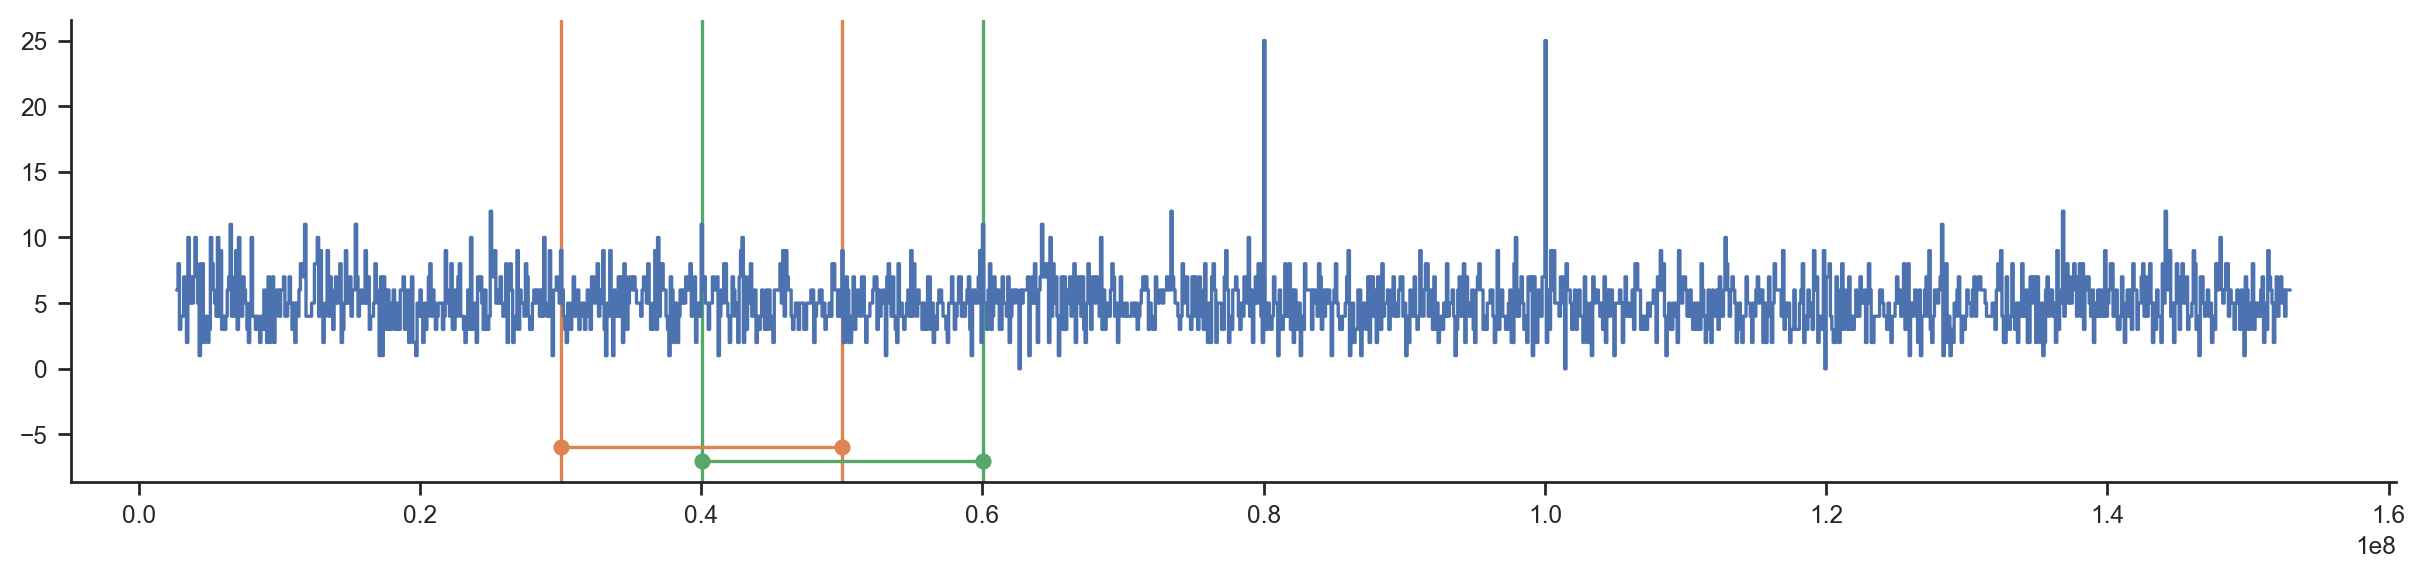

In [73]:
plt.figure(figsize=(15, 3))
plot_df = df.groupby('start').is_north.sum().to_frame('is_north').reset_index()
plot_df['end'] = plot_df.start + window_size
plot_df = stairs(plot_df)
plt.plot(plot_df.pos, plot_df.is_north)
y = -1

for i, (a, b) in enumerate(pp_interacting_windows):
    plt.axvline(a*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
    plt.axvline(b*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
    plt.plot([a*window_size+window_size/2, b*window_size+window_size/2], [y, y], '-o', color=f'C{i+1}')
    y -= 1
y -= 5
for i, (a, b) in enumerate(mi_interacting_windows):
    plt.axvline(a*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
    plt.axvline(b*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
    plt.plot([a*window_size+window_size/2, b*window_size+window_size/2], [y, y], '-o', color=f'C{i+1}')
    y -= 1
sns.despine()

## TODO

- Support female genotypes
- Take admixture proportion into account instead of assuming 50%.